In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import random_split
%matplotlib inline


import os
# os.listdir(os.getcwd())

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [5]:
import pandas as pd


## Decoding Gene-Expression Patterns: Deep Learning Approaches to Sample Type Prediction in RNASeq Data

There has been a surge of interest in RNASeq data analysis in recent years, primarily driven by advances in high-throughput sequencing methodologies. These analyses predominantly aim to identify differentially expressed genes or gene clusters across various tissue types or experimental treatments. The inverse problem of predicting sample types from gene expression patterns is equally significant but has garnered relatively little attention, partly due to the following reasons:

A limited number of samples are typically available for a given condition, treatment, or tissue type in most studies.
RNASeq data from different conditions lack control for variations or fluctuations arising from diverse experimental conditions.
In this article, we have adopted a method—specifically, deep learning in feedforward networks—that, when applied in conjunction with the identified problem, holds the potential to address these two challenges


### The Problem at Hand: Discerning the Wildtype Identity from Gene-Expression Data

The crux of our challenge lies in identifying whether a given sample originates from an unperturbed wildtype, solely based on gene-expression data. To comprehensively explore the impact of a specific perturbation, experimenters meticulously design their studies, incorporating multiple controls where the organism remains untouched by the perturbation. This practice extends to mock treatments or controls for the wildtypes of the model organism. Even in studies focusing on the effects of a treatment on a particular mutant genotype, a wildtype equivalent is typically included with controls. Consequently, a wealth of RNASeq data is available for wildtype controls, presenting an opportunity for leveraging data-hungry algorithms, such as supervised deeplearning algorithms.

Deeplearning algorithms, functioning within neural networks, exhibit the capacity to discern the identity of sample types across various studies, even when they differ in their total transcript levels. Proficient in capturing non-linear relationships, these algorithms excel at unraveling the intricate interconnections among genes that define a specific sample type, in this case, a wild-type control. This article explores the potential of utilizing these algorithms to extract meaningful insights from diverse RNASeq datasets, showcasing their ability to transcend study-specific variations and illuminate the underlying biological patterns.

### Model Organism: Arabidopsis thaliana

We opted for Arabidopsis thaliana as our model organism for this analysis, although the outlined steps can be adjusted for other organisms with extensive RNASeq data repositories. The dataset used in the following steps is a compilation from various RNASeq studies. Each dataset was individually downloaded and subjected to one or two preprocessing steps. The procedures were as follows:

Data Acquisition:

We used the SRAtoolkits from NCBI to systematically download RNASeq data from selected studies, forming the foundational dataset.

Filtering for Wildtype Controls:

Further filtering steps were applied on metadata from the SRA selector. This process specifically isolated wildtype control treatments from conditions involving perturbations, mutant genotypes, or mutants undergoing perturbing treatments.

Transcript Quantification:

The Salmon package quantified transcript levels without genome alignment, and Tximport, an R library, facilitated the creation of gene-level aggregates.

Data Refinement:

For quality enhancement, genes with no expression in over 75 percent of the samples were removed. Additionally, outliers with significant and erratic fluctuations were identified and eliminated.

The 'run' command in the 'Salmon' package differs between single-read RNASeq data and paired-read RNASeq data. To facilitate easier labeling later on, we must streamline the processing of wild-type control and perturbed samples separately. Consequently, we generated four distinct data sources, which we will download and combine in the next few blocks of code

Downloading and processing the wildtype-control RNASeq data that were generated via paired-end sequencing

In [6]:
## loading the gene-expression data for the wildtype
wildtype_control = pd.read_csv("data/deeplearnData_wildtypeVsPerturbed/wildtype_control_paired_geneexp_quant.csv", delimiter=",")
## the first 86 columns include the abundance levels for all the wildtype-control samples we will be using. They include both the training and the validation data
all_abundance = wildtype_control.columns[:87]
abundance_wt = wildtype_control[all_abundance]
## renaming the first column into 'gene_id' ...
abundance_wt = abundance_wt.rename({'Unnamed: 0': 'gene_id'}, axis='columns')

## removing the gene_id columns from the df. No strings attached to the df now. 
abundance_wt_nums = abundance_wt.drop(labels=['gene_id',], axis=1)
#wildtype_control.columns[173:173+86]
#sorted(abundance_wt_nums.std(axis=1))[-1::-1][:300]

##-# Removing the genes with more than 85 percent of no-expressions are removed
abundance_wt_zeroslocs = (abundance_wt_nums == 0.0)
abundance_wt['num_zero_cols'] = abundance_wt_zeroslocs.sum(axis=1)
abundance_wt = abundance_wt[abundance_wt['num_zero_cols'] < 73]


In [7]:
# plt.hist(abundance_wt['num_zero_cols'])
# 73/86

We also removed some outlier genes with extreme fluctuations across samples. The functions and sections of code below implement this.

In [8]:
def giveNonZeroMean(vec):
    vec = vec[vec > 0]
    m = np.mean(vec)
    return m

def giveNonZeroStd(vec):
    vec = np.array(vec[vec > 0])
    std = np.std(vec)
    return std


In [9]:
# (73/86)*193

In [10]:
abundance_wt_red_nums = abundance_wt.drop(labels=['gene_id',], axis=1)
abundance_wt['non_zero_mean'] = abundance_wt_red_nums.apply(giveNonZeroMean, axis=1)
abundance_wt['non_zero_std'] = abundance_wt_red_nums.apply(giveNonZeroStd, axis=1)

abundance_wt['non_zero_std'].describe()
std_threshold = abundance_wt['non_zero_std'].quantile(0.95)
abundance_wt = abundance_wt[abundance_wt['non_zero_std'] < std_threshold]
abundance_wt_red_nums = abundance_wt.drop(labels=['gene_id',], axis=1)
abundance_wt['non_zero_std'].describe()


count    8200.000000
mean        8.434011
std         8.647759
min         0.158049
25%         2.567632
50%         5.740215
75%        11.637797
max        55.943049
Name: non_zero_std, dtype: float64

Downloading and processing the perturbed RNASeq data that were generated via paired-end sequencing 

In [11]:
perturbed_data = pd.read_csv("data/deeplearnData_wildtypeVsPerturbed/perturbed_paired_geneexp_quant.csv", delimiter=",")

all_abundance_pt = perturbed_data.columns[:194]
abundance_pt =perturbed_data[all_abundance_pt]
abundance_pt = abundance_pt.rename({'Unnamed: 0': 'gene_id'}, axis='columns')

abundance_pt_nums = abundance_pt.drop(labels=['gene_id',], axis=1)

abundance_pt_zeroslocs = (abundance_pt_nums == 0.0)
abundance_pt['num_zero_cols'] = abundance_pt_zeroslocs.sum(axis=1)
abundance_pt = abundance_pt[abundance_pt['num_zero_cols'] < 163]


abundance_pt_red_nums = abundance_pt.drop(labels=['gene_id',], axis=1)
abundance_pt['non_zero_mean'] = abundance_pt_red_nums.apply(giveNonZeroMean, axis=1)
abundance_pt['non_zero_std'] = abundance_pt_red_nums.apply(giveNonZeroStd, axis=1)

# abundance_wt['non_zero_std'].describe()
std_threshold = abundance_pt['non_zero_std'].quantile(0.95)
abundance_pt = abundance_pt[abundance_pt['non_zero_std'] < std_threshold]
abundance_pt['non_zero_std'].describe()


count    6660.000000
mean       28.160149
std        29.203524
min        13.545419
25%        15.188461
50%        18.058692
75%        24.900695
max       210.412980
Name: non_zero_std, dtype: float64

Downloading and processing the wildtype-control RNASeq data that were generated from single-end reads 

In [12]:
wildtype_control_sngl = pd.read_csv("data/deeplearnData_wildtypeVsPerturbed/wildType_control_singleReads_geneexp_quant.csv", delimiter=",")

all_abundance_wt_sngl =  wildtype_control_sngl.columns[:69]

abundance_wt_sngl = wildtype_control_sngl[all_abundance_wt_sngl]
abundance_wt_sngl = abundance_wt_sngl.rename({'Unnamed: 0': 'gene_id'}, axis='columns')

abundance_wt_nums_sngl = abundance_wt_sngl.drop(labels=['gene_id',], axis=1)

abundance_wt_zeroslocs_sngl = (abundance_wt_nums_sngl == 0.0)
abundance_wt_sngl['num_zero_cols'] = abundance_wt_zeroslocs_sngl.sum(axis=1)
abundance_wt_sngl = abundance_wt_sngl[abundance_wt_sngl['num_zero_cols'] < 57]


abundance_wt_red_nums_sngl = abundance_wt_sngl.drop(labels=['gene_id',], axis=1)
abundance_wt_sngl['non_zero_mean'] = abundance_wt_red_nums_sngl.apply(giveNonZeroMean, axis=1)
abundance_wt_sngl['non_zero_std'] = abundance_wt_red_nums_sngl.apply(giveNonZeroStd, axis=1)


std_threshold = abundance_wt_sngl['non_zero_std'].quantile(0.95)
abundance_wt_sngl = abundance_wt_sngl[abundance_wt_sngl['non_zero_std'] < std_threshold]
abundance_wt_sngl['non_zero_std'].describe()

count    15133.000000
mean        11.295568
std          8.392437
min          0.799510
25%          5.395523
50%         11.487465
75%         13.462329
max         52.041166
Name: non_zero_std, dtype: float64

Downloading and processing the perturbed RNASeq data that were generated from single-end reads

In [13]:
perturbed_data_sngl = pd.read_csv("data/deeplearnData_wildtypeVsPerturbed/perturbed_singleReads_geneexp_quant.csv", delimiter=",")

all_abundance_pt_sngl =  perturbed_data_sngl.columns[:251]
abundance_pt_sngl =perturbed_data_sngl[all_abundance_pt_sngl]
abundance_pt_sngl = abundance_pt_sngl.rename({'Unnamed: 0': 'gene_id'}, axis='columns')

abundance_pt_nums_sngl = abundance_pt_sngl.drop(labels=['gene_id',], axis=1)

abundance_pt_zeroslocs_sngl = (abundance_pt_nums_sngl == 0.0)
abundance_pt_sngl['num_zero_cols'] = abundance_pt_zeroslocs_sngl.sum(axis=1)
abundance_pt_sngl = abundance_pt_sngl[abundance_pt_sngl['num_zero_cols'] < 212]


abundance_pt_red_nums_sngl = abundance_pt_sngl.drop(labels=['gene_id',], axis=1)
abundance_pt_sngl['non_zero_mean'] = abundance_pt_red_nums_sngl.apply(giveNonZeroMean, axis=1)
abundance_pt_sngl['non_zero_std'] = abundance_pt_red_nums_sngl.apply(giveNonZeroStd, axis=1)


std_threshold = abundance_pt_sngl['non_zero_std'].quantile(0.95)
abundance_pt_sngl = abundance_pt_sngl[abundance_pt_sngl['non_zero_std'] < std_threshold]
abundance_pt_sngl['non_zero_std'].describe()

count    7139.000000
mean       31.705868
std        33.506427
min        12.407931
25%        15.743637
50%        20.297687
75%        29.832315
max       230.701413
Name: non_zero_std, dtype: float64

We will select the genes that were present in all of the four dataframes generated in the above codes. All furhter analysis will proceed with these select genes.

In [14]:
gene_ids_wtControl = abundance_wt.gene_id
gene_ids_pt = abundance_pt.gene_id
gene_ids_wtControl_sngl = abundance_wt_sngl.gene_id
gene_ids_pt_sngl = abundance_pt_sngl.gene_id
# gene_list_selected = list(set(gene_ids_wtControl) & set(gene_ids_pt))
gene_list_selected_all = list(set(gene_ids_wtControl_sngl) & set(gene_ids_pt_sngl) & set(gene_ids_pt) & set(gene_ids_wtControl))


abundance_wt_mask = abundance_wt['gene_id'].isin(gene_list_selected_all)
abundance_wt = abundance_wt[abundance_wt_mask]
abundance_pt_mask = abundance_pt['gene_id'].isin(gene_list_selected_all)
abundance_pt = abundance_pt[abundance_pt_mask]
abundance_wt_sngl_mask = abundance_wt_sngl['gene_id'].isin(gene_list_selected_all)
abundance_wt_sngl = abundance_wt_sngl[abundance_wt_sngl_mask]
abundance_pt_sngl_mask = abundance_pt_sngl['gene_id'].isin(gene_list_selected_all)
abundance_pt_sngl = abundance_pt_sngl[abundance_pt_sngl_mask]

In [15]:
from IPython.display import YouTubeVideo

Most of the codes I used below were derived from the tutorials and lectured due to Aakash Rao. The link to the video lectures and notebooks is given below. I have modified his codes to suit our need. 

Find the notebook where the feedforward network were used to train on image classification data.

https://jovian.ml/aakashns/04-feedforward-nn

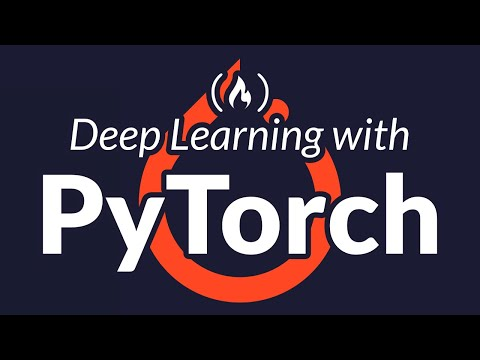

In [16]:
YouTubeVideo('GIsg-ZUy0MY', width=800, height=300)

The class definition provided below outlines the architecture of the feedforward neural network we employ. Within its methods, there are functions designed to compute an output based on a given input to the neural network, calculate the loss (measured by cross-entropy in this context) for a given output, evaluate the accuracy of an output, estimate the mean of the losses and accuracies from the outputs of an epoch, and report those means

In [17]:
class RNASeqModel(nn.Module):
    """Feedforward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size1, hidden_size2, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, hidden_size1)
        # hidden layer 2
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        # output layer
        self.linear3 = nn.Linear(hidden_size2, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        ## Get intermediate outputs using hidden layer1
        out = self.linear1(xb)
        ## Apply activation function1
        out = F.relu(out)

        ## Get intermediate outputs using hidden layer2
        out = self.linear2(out)
        ## Apply activation function2
        out = F.relu(out)

        ## Get predictions using output layer
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss':loss, 'val_acc':acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x["val_acc"] for x in outputs] 
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [19]:
# ind_where_genes_pt = [i for i,e in enumerate(abundance_pt.gene_id) if e in set(abundance_wt_noOutliers.gene_id)] 
# ind_where_genes_pt
# abundance_pt.gene_id
# abundance_pt.loc[ind_where_genes_pt]


In the upcoming section, we are consolidating all the individual dataframes containing gene expression levels into a unified NumPy array, incorporating the corresponding labels denoting whether they are wildtype-control or perturbed samples. To harness the parallelization capabilities of GPUs, we will convert these arrays into tensors. As an arbitrary choice, we've assigned the binary variable 1 to represent wildtype-control and 0 for perturbed samples. The specific value chosen for wildtype-control is inconsequential, as long as we maintain consistency with this initial choice throughout the subsequent workflow. In the final step, we amalgamated the gene expression data and corresponding labels into a Python dictionary.

In [20]:
abundance_wt.columns
abundance_wt_nums = abundance_wt.drop(labels=['gene_id','non_zero_mean', 'num_zero_cols',  'non_zero_std' ], axis=1)
abundance_wt_nums = np.asarray(abundance_wt_nums, dtype='float32')
abundance_pt_nums = abundance_pt.drop(labels=['gene_id','non_zero_mean', 'num_zero_cols',  'non_zero_std' ], axis=1)
abundance_pt_nums = np.asarray(abundance_pt_nums, dtype='float32')

abundance_wt_sngl_nums = abundance_wt_sngl.drop(labels=['gene_id','non_zero_mean', 'num_zero_cols',  'non_zero_std' ], axis=1)
abundance_wt_sngl_nums = np.asarray(abundance_wt_sngl_nums, dtype='float32')
abundance_pt_sngl_nums = abundance_pt_sngl.drop(labels=['gene_id','non_zero_mean', 'num_zero_cols',  'non_zero_std' ], axis=1)
abundance_pt_sngl_nums = np.asarray(abundance_pt_sngl_nums, dtype='float32')

np.random.seed(1)

random_indices = np.random.choice(np.arange(abundance_pt_nums.shape[1]), abundance_wt_nums.shape[1], replace=False)
print(len(random_indices))
abundance_pt_nums = abundance_pt_nums.T[random_indices]
abundance_pt_nums = abundance_pt_nums.T
abundance_pt_nums.shape

random_indices = np.random.choice(np.arange(abundance_pt_sngl_nums.shape[1]), abundance_wt_sngl_nums.shape[1], replace=False)
print(len(random_indices))
abundance_pt_sngl_nums = abundance_pt_sngl_nums.T[random_indices]
abundance_pt_sngl_nums = abundance_pt_sngl_nums.T
abundance_pt_sngl_nums.shape

RNAexp_data = np.hstack([abundance_wt_nums,abundance_wt_sngl_nums, abundance_pt_nums, abundance_pt_sngl_nums])
RNAexp_label = np.hstack([np.ones(abundance_wt_nums.shape[1]), np.ones(abundance_wt_sngl_nums.shape[1]), np.zeros(abundance_pt_nums.shape[1]), np.zeros(abundance_pt_sngl_nums.shape[1])])
RNAexp_data = torch.from_numpy(RNAexp_data)
RNAexp_label = torch.from_numpy(RNAexp_label)
RNAexp_label = torch.tensor(RNAexp_label, dtype=torch.long)

myData = {'samples':RNAexp_data, 'labels':RNAexp_label}
len(myData['samples'])

86
68


C:\Users\Acer\AppData\Local\Temp\ipykernel_12180\3303891757.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  RNAexp_label = torch.tensor(RNAexp_label, dtype=torch.long)


6240

An helper class as recommended by pytorch to ease our data into the 'dataset' and 'dataloader' utilities is implemented below. This one inherits the attrributes and methods of Dataset class.

In [21]:
class RNASeqDataset(Dataset):
    def __init__(self, myData):
        self.samples = myData['samples']
        self.labels = myData['labels']        
    def __len__(self):
        return len(self.samples[0,:])

    def __getitem__(self, idx):
        return (self.samples[:,idx], self.labels[idx])


A dataset object is created with our custom-made class RNASeqDataset

In [22]:
dataset = RNASeqDataset(myData)
len(dataset)

308


The dataset will be divided into three segments: a training set, an evaluation set, and a test set. The following code block outlines key parameters related to the dataset sizes and batch configurations for use in the training procedure.

In [23]:

batch_size_train = 50
batch_size_val = 50
batch_size_test = 58

# dataset = RNASeqDataset(myData)#TensorDataset(torch.from_numpy(RNAexp_data).squeeze(1), torch.from_numpy(RNAexp_label))
val_size = 50
test_size = 58
train_size = len(dataset) - val_size - test_size


train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

train_loader = DataLoader(train_ds, batch_size_train, shuffle=True,  pin_memory=True)
val_loader = DataLoader(val_ds, batch_size_val,  pin_memory=True)
test_loader = DataLoader(test_ds, batch_size_test,  pin_memory=True)

Below are the parameters defining the size (number of nodes/neurons) of the different layers: input layer, hidden layers 1 & 2, and output layer. Though the intial sizes of the hidden layers are set heuristically, we have used the evaluation set later on to fine-tune them. The number of genes we have decided upon dictates the size the input layer. And the nature of the problem, binary classification, dictates the size of the output layer.

In [24]:
for inputs, labels in train_loader:
    
    print('inputs.shape:', inputs.shape)
    break

inputs.shape: torch.Size([50, 6240])


In [ ]:
# for inputs, labels in train_loader:
#     outputs = model(inputs)
#     loss = F.cross_entropy(outputs, labels)
#     print('loss', loss.item())
#     break

All the helper functions to send the data as well as the model are in the next block. The custom-class wraps around the dataloader dl to send the data to GPU.

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    "Move tensor(s) to chosen device"
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to a given device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [26]:
device = get_default_device()
device

device(type='cuda')

New custom dataloaders, objects of DeviceDataLoader class defined above, modifying the original dataloaders we defined using the pytorch utility so that they are GPU-ready

In [27]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [28]:
for xb, yb in val_loader:
    print('xb.device: ', xb.device)
    print('yb:',yb)
    break

xb.device:  cuda:0
yb: tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0], device='cuda:0')


Functions to train (fit) and evaluate the model.

The number of epochs (epochs) and learning rate (lr) that controls the rate of converging to the optimum parameters are some other hyperparameters (apart from those that define the architecture of the neural network) that are defined heuristically. We will use the evaluation dataset to find a better learning rate than the default one.

In [29]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_fun = torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_fun(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation Phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

We will construct a model object using the RNASeqModel class we defined before and send that model to the gpu device. We evaluate the nascent, naive model to ascertain that it is indeed performing poorly.

In [30]:
input_size = 6240
hidden_size1 = 6240
hidden_size2 = 1000
num_classes = 2

model = RNASeqModel(input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2, out_size=num_classes)
to_device(model, device)

history = [evaluate(model, val_loader)]
history


[{'val_loss': 1.0183812379837036, 'val_acc': 0.3799999952316284}]

We will train the model using our data as streamlined through train_loader and evaluate and report its progress across the epochs (8 here). The learning rate is set to 0.005, which we will try to improve. 

In [31]:


history += fit(8, 0.005, model, train_loader, val_loader)

Epoch [0], val_loss: 2.4173, val_acc: 0.7800
Epoch [1], val_loss: 0.4523, val_acc: 0.7800
Epoch [2], val_loss: 0.2657, val_acc: 0.9000
Epoch [3], val_loss: 0.3032, val_acc: 0.8800
Epoch [4], val_loss: 0.2378, val_acc: 0.9000
Epoch [5], val_loss: 0.6602, val_acc: 0.8000
Epoch [6], val_loss: 0.2862, val_acc: 0.8400
Epoch [7], val_loss: 0.2424, val_acc: 0.9200


Here, we would like to know how varying learning rate affects the evolution of accuracy in the validation data set as we train the data on the training data set over many epochs. Based on this evolution, we can choose the learning rate parameter that leads to smooth attainment of optimal parameters in a timely manner. We have compared the evolution of accuracy from a naive model to a trained model at the end of 15 epochs for five different learning rates. From an visual inspection we will choose a learning rate for further training experiments later on.

Epoch [0], val_loss: 0.4423, val_acc: 0.7800
Epoch [1], val_loss: 0.3519, val_acc: 0.8600
Epoch [2], val_loss: 0.3867, val_acc: 0.8200
Epoch [3], val_loss: 0.2777, val_acc: 0.8800
Epoch [4], val_loss: 0.2554, val_acc: 0.8800
Epoch [5], val_loss: 0.2166, val_acc: 0.9200
Epoch [6], val_loss: 0.2101, val_acc: 0.9400
Epoch [7], val_loss: 0.1884, val_acc: 0.9400
Epoch [8], val_loss: 0.1819, val_acc: 0.9400
Epoch [9], val_loss: 0.1770, val_acc: 0.9400
Epoch [10], val_loss: 0.2126, val_acc: 0.9400
Epoch [11], val_loss: 0.1958, val_acc: 0.9400
Epoch [12], val_loss: 0.1763, val_acc: 0.9400
Epoch [13], val_loss: 0.2061, val_acc: 0.9400
Epoch [14], val_loss: 0.1560, val_acc: 0.9400
Epoch [0], val_loss: 0.6702, val_acc: 0.7800
Epoch [1], val_loss: 0.3805, val_acc: 0.8400
Epoch [2], val_loss: 0.3287, val_acc: 0.8200
Epoch [3], val_loss: 0.3798, val_acc: 0.8200
Epoch [4], val_loss: 0.2257, val_acc: 0.9600
Epoch [5], val_loss: 0.2317, val_acc: 0.9600
Epoch [6], val_loss: 0.3086, val_acc: 0.8600
Epoch

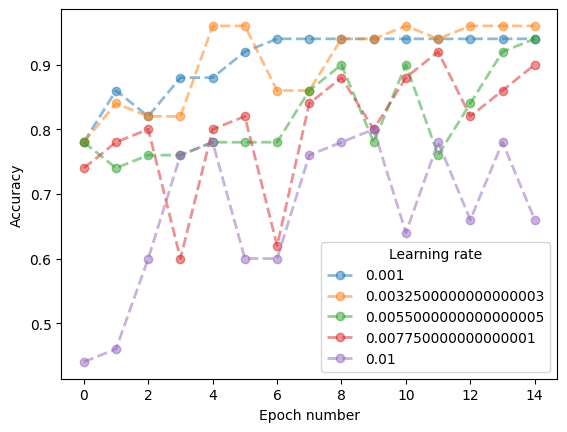

In [32]:
input_size = 6240
hidden_size1 = 6240
hidden_size2 = 1000
num_classes = 2

l_lr = np.linspace(0.001,0.01,5)
l_history = {'l_history':[], 'l_lr':l_lr}
for lr in l_lr:

    model = RNASeqModel(input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2, out_size=num_classes)
    to_device(model, device)
    history = []
    history += fit(15, lr, model, train_loader, val_loader)
    # history += fit(15, lr, model, train_loader, val_loader)

    l_history['l_history'].append(history)

l_hist = l_history['l_history']
## l_hist is list of list of dictionaries
l_hist_arr = []
for i,l_h in enumerate(l_hist):
    l_arr_loss = []
    for j,res in enumerate(l_h):
        l_arr_loss.append(res['val_acc'])
    l_arr_loss = np.asarray(l_arr_loss)
    l_hist_arr.append(l_arr_loss)


for i, l_h in  enumerate(l_hist_arr):
    plt.plot(l_h, label=l_lr[int(i)], ls="--", marker='o', lw=2, alpha=0.5)
plt.legend(title="Learning rate")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.show()

As we can see from comparing among the five different learning rates, there is generally an improvement in accuracy from the initial epochs to the later epochs. Higher learning rates lead to sub-optimal performance in terms of steady-state accuracy and time to reach the peak accuracy. So, we will use the lowest of the learning rates for later explorations.   

In [33]:
## A helper function to build and train a model that yields the accuracy measurements from the end of epochs of learning. 
## We will use this function to explore the effect of architecture of the feedforward neural network on its performance.
def yield_accs_history(hidden_layer_size):
    
    input_size = 6240
    hidden_size1 = hidden_layer_size
    hidden_size2 = hidden_layer_size
    num_classes = 2

    nTrials = 10
    lr = 0.001 
    l_dict_history_alltrials = {'l_history':[], 'hidden_size1':hidden_size1, 'hidden_size2':hidden_size2}

    for trial in range(nTrials):

        model = RNASeqModel(input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2, out_size=num_classes)
        to_device(model, device)

        history = []
        history += fit(15, lr, model, train_loader, val_loader)
        l_dict_history_alltrials['l_history'].append(history)

    return l_dict_history_alltrials

We use a feedforward neural network with two hidden layers with same number of nodes in each of them. This is so that we keep the complexity lower than if there were two hidden layers with differeing number of nodes in each of them. As a result, there is only one parameter to explore (size of the hidden layers) instead of there being two.

In [34]:
## list of hidden layer sizes
l_hs = [24960, 12480, 6240, 3120, 1560, 780, 500]

## Let us store the history of accuuracies in the l_history vector
l_history = []
for hidden_layer_size in l_hs:
    l_history.append(yield_accs_history(hidden_layer_size))

Epoch [0], val_loss: 0.6288, val_acc: 0.8400
Epoch [1], val_loss: 0.3575, val_acc: 0.9200
Epoch [2], val_loss: 0.3461, val_acc: 0.9200
Epoch [3], val_loss: 0.2149, val_acc: 0.9400
Epoch [4], val_loss: 0.2427, val_acc: 0.9600
Epoch [5], val_loss: 0.2689, val_acc: 0.9400
Epoch [6], val_loss: 0.2105, val_acc: 0.9600
Epoch [7], val_loss: 0.2083, val_acc: 0.9600
Epoch [8], val_loss: 0.2221, val_acc: 0.9600
Epoch [9], val_loss: 0.2468, val_acc: 0.9600
Epoch [10], val_loss: 0.2336, val_acc: 0.9600
Epoch [11], val_loss: 0.2392, val_acc: 0.9600
Epoch [12], val_loss: 0.2344, val_acc: 0.9600
Epoch [13], val_loss: 0.2395, val_acc: 0.9600
Epoch [14], val_loss: 0.2417, val_acc: 0.9600
Epoch [0], val_loss: 17.2398, val_acc: 0.7800
Epoch [1], val_loss: 0.8912, val_acc: 0.8600
Epoch [2], val_loss: 0.7132, val_acc: 0.9200
Epoch [3], val_loss: 0.5463, val_acc: 0.9400
Epoch [4], val_loss: 0.5127, val_acc: 0.9400
Epoch [5], val_loss: 0.4192, val_acc: 0.9400
Epoch [6], val_loss: 0.3698, val_acc: 0.9400
Epoc

In [35]:
## Extracting the accuracies from l_history vector
l_hist_arr = []
for i,l_h in enumerate(l_history):
    lol_arr_loss = []
    for j,his in enumerate(l_h['l_history']):
        l_arr_loss = []
        for k,res in enumerate(his):
            l_arr_loss.append(res['val_acc'])
        l_arr_loss = np.asarray(l_arr_loss)
        lol_arr_loss.append(l_arr_loss)
    l_hist_arr.append(lol_arr_loss)

In [36]:
len(l_hist_arr)

7

We have built neural networks with different hidden layer sizes. For each of these networks, we repeated the training for ten trials. The plots below show the evolution of accuracies (as calculated from the validation set) for the ten trials of learning from scratch on the same network. 

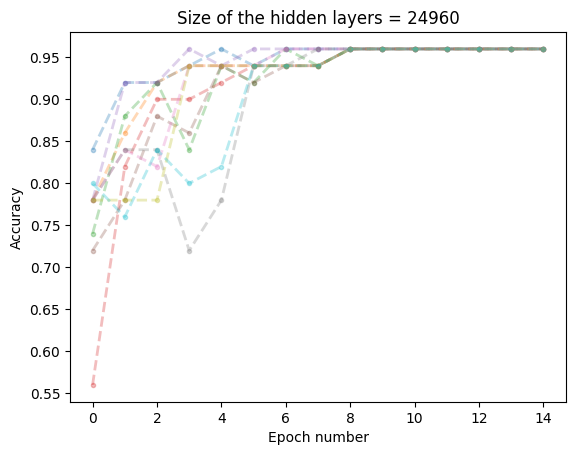

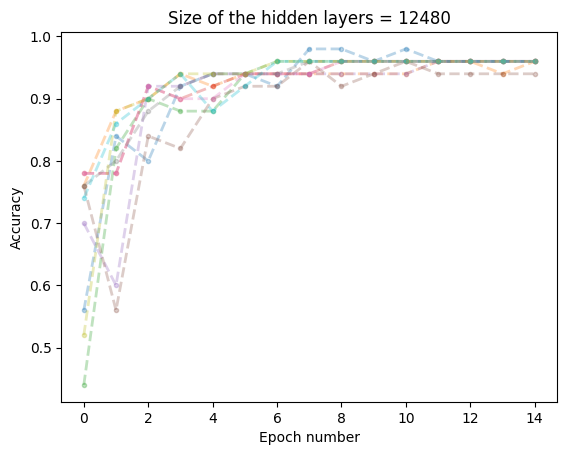

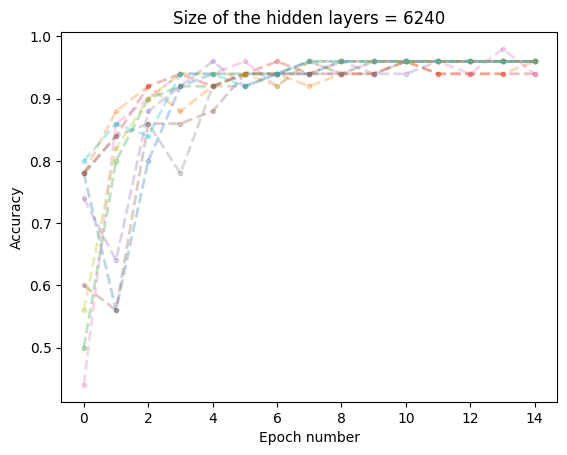

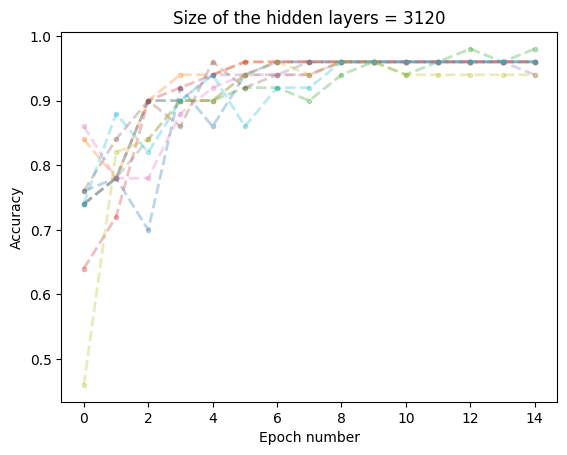

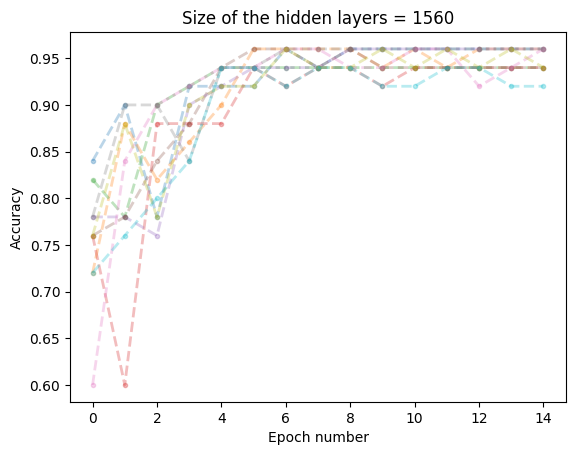

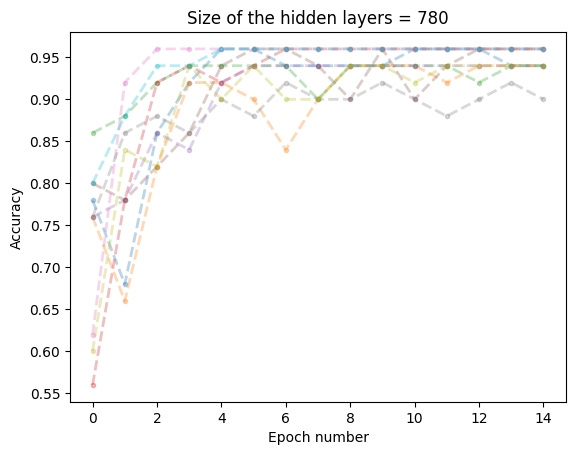

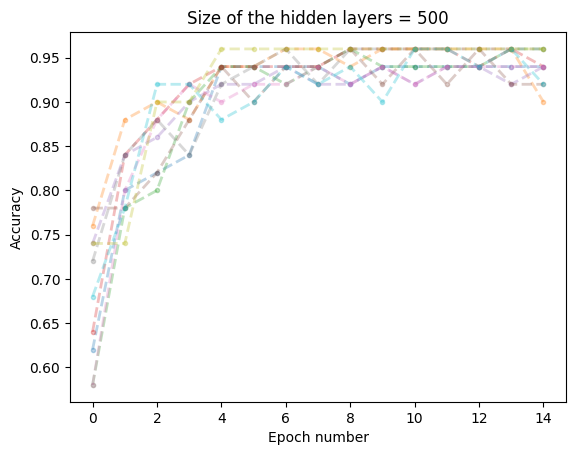

In [37]:
## plotting the increase in accuracies for all the neural networks
for i, l_h in  enumerate(l_hist_arr):
    for j,his in enumerate(l_h):
        plt.plot(his, label=i, ls="--", marker='.', lw=2, alpha=0.3)
    plt.title("Size of the hidden layers = {}".format(l_hs[i]))
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.show()


From the plots above, we can immediately see that there is a general trend of increasing accuracies with more and more epochs of training. Also, the naive networks showed more variation across trials than the learned network with more mean accuracies. While the network with the least number of nodes in a given hidden layer show increased variation in accuracies across trials at later epochs, there is not much difference across the networks with higher sized hidden layers. 

We have choosen one of the network from the above (with hidden layer size 3120) and will train it again with the training data set. The evaluation of it's performance will be simulataneously reported with data from evaluation data set. Once the training is completed, we will test its performance on test data that was neither used for training nor for evaluation to find the optimal hyperparameters (learning rate or hidden layer size).  

In [42]:
input_size = 6240
hidden_size1 = 24960
hidden_size2 = 24960
num_classes = 2

lr = 0.001 

model = RNASeqModel(input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2, out_size=num_classes)
to_device(model, device)

history = []
history += fit(15, lr, model, train_loader, val_loader)
# history += fit(15, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 3.0751, val_acc: 0.7800
Epoch [1], val_loss: 1.4961, val_acc: 0.8200
Epoch [2], val_loss: 0.9899, val_acc: 0.8200
Epoch [3], val_loss: 0.5047, val_acc: 0.9200
Epoch [4], val_loss: 0.8516, val_acc: 0.9000
Epoch [5], val_loss: 0.3206, val_acc: 0.9400
Epoch [6], val_loss: 0.4330, val_acc: 0.9200
Epoch [7], val_loss: 0.3301, val_acc: 0.9600
Epoch [8], val_loss: 0.3624, val_acc: 0.9600
Epoch [9], val_loss: 0.3639, val_acc: 0.9600
Epoch [10], val_loss: 0.3751, val_acc: 0.9600
Epoch [11], val_loss: 0.3817, val_acc: 0.9600
Epoch [12], val_loss: 0.3901, val_acc: 0.9600
Epoch [13], val_loss: 0.3833, val_acc: 0.9600
Epoch [14], val_loss: 0.3887, val_acc: 0.9600


The trained model with the highest number of node sizes explored so far showed a performance of 96 percent accuracy in the validation data set. Below, we will compute its accuracy of prediction on the data from the test data.

In [43]:
evaluate(model, test_loader)

{'val_loss': 1.6410340070724487, 'val_acc': 0.8275862336158752}

An accuracy of 82 percent shows that there might be some overfitting in the large neural network.

In [44]:
input_size = 6240
hidden_size1 = 3120
hidden_size2 = 3120
num_classes = 2

lr = 0.001 

model = RNASeqModel(input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2, out_size=num_classes)
to_device(model, device)

history = []
history += fit(15, lr, model, train_loader, val_loader)
# history += fit(15, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8219, val_acc: 0.6800
Epoch [1], val_loss: 0.2782, val_acc: 0.9000
Epoch [2], val_loss: 0.3195, val_acc: 0.8800
Epoch [3], val_loss: 0.1677, val_acc: 0.9400
Epoch [4], val_loss: 0.1470, val_acc: 0.9400
Epoch [5], val_loss: 0.2890, val_acc: 0.9000
Epoch [6], val_loss: 0.1632, val_acc: 0.9600
Epoch [7], val_loss: 0.1389, val_acc: 0.9600
Epoch [8], val_loss: 0.1220, val_acc: 0.9800
Epoch [9], val_loss: 0.1505, val_acc: 0.9600
Epoch [10], val_loss: 0.1405, val_acc: 0.9600
Epoch [11], val_loss: 0.1442, val_acc: 0.9600
Epoch [12], val_loss: 0.1425, val_acc: 0.9600
Epoch [13], val_loss: 0.1225, val_acc: 0.9600
Epoch [14], val_loss: 0.1457, val_acc: 0.9600


In [45]:
evaluate(model, test_loader)

{'val_loss': 0.6144965887069702, 'val_acc': 0.8620689511299133}

An accuracy of prediction of 96 percent in the validation set and 86 percent accuracy in the test set is comparable to that of the largest network before. Though the two networks show a significant level of generalization, the smaller size offers the benefit of computaional efficiency.

### Summary

We have been able to use a supervised learning algorithm on feedforward neural networks to detect the hidden patterns in RNASeq data of whole seedling samples from *Arabidopsis thaliana*. The network, upon learning from the training samples, learned to identify the wildtype samples that were not undergone any treatments as opposed to perturbed samples that either were mutants or had undergone a perturbation of some sort (this included mutant samples that had perturbation as well). In a natural next step, we would like to understand what signature patterns from the RNASeq data the neural network used to identify the nature of the sample. One disadvantage of highly complex models like neural networks is that they are mostly helpless in situation where an explanation is needed to understand the mechanism of decision making. In contrast, simple models like linear regression, though biased to identify only linear associations, are amenable for identifying features that lead to a particular output/prediction. Recent advances in deeplearning models (explainable AI) can partially rectify this issue.
















